In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
import pyranges as pr
from statannotations.Annotator import Annotator
import itertools

from basenji import dataset
from utils.call_peaks import call_peaks
from utils.eqtl_classification import *

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
root_dir = "/clusterfs/nilah/pooja"
fig_dir = f"{root_dir}/CellTypeSpecificAccessibilityPrediction/figures"

### Reference accuracy

Enformer

In [5]:
data_dir = "/clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human"
human_targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", index_col=0)
dnase_atac_targets = np.where([("DNASE" in i) or ("ATAC" in i) 
                               for i in human_targets["description"]])[0]

In [6]:
sequences = pd.read_csv(f"{data_dir}/sequences.bed", sep="\t",
                        names=["chr", "start", "end", "fold"])
sequences = sequences[sequences["fold"] == "test"]
sequences["bins"] = sequences.apply(lambda x: np.array([(x.chr, x.start + 8192 + (128*i), x.start + 8192 + (128*(i+1))) for i in range(896)]), axis=1)
sequence_bins = np.stack(sequences["bins"].values)                                              

In [10]:
# read in targets
eval_data = dataset.SeqDataset(data_dir,
    split_label="test",
    batch_size=4,
    mode='eval',
    tfr_pattern=None,
    float_type="float16")
targets = eval_data.numpy(return_inputs=False, return_outputs=True)

test_targets_dnase_ds = targets[:, :, dnase_atac_targets].reshape(-1,len(dnase_atac_targets))
sequence_bins_ds = sequence_bins.reshape(-1, 3)
assert test_targets_dnase_ds.shape[0] == sequence_bins_ds.shape[0]

In [ ]:
print("calling peaks..")
test_targets_dnase_ds_peaks = call_peaks(test_targets_dnase_ds, return_full=True)
peak_in_num_cell_types = test_targets_dnase_ds_peaks.sum(axis=1)

calling peaks..


In [15]:
# read in predictions
predictions = h5py.File(f"/global/scratch/users/poojakathail/enformer/test/predict.h5", "r")
preds = np.array(predictions["preds"])

test_preds_dnase = preds[:, :, dnase_atac_targets]
test_preds_dnase_ds = test_preds_dnase.reshape(-1, 684)

In [ ]:
# filter targets and predictions to only those in peaks
peak_inds = np.where(peak_in_num_cell_types >= 1)[0]
test_targets_dnase_ds_in_peaks = test_targets_dnase_ds[peak_inds,:]
test_targets_dnase_ds_in_peaks_binary = test_targets_dnase_ds_peaks[peak_inds,:]
test_preds_dnase_ds_in_peaks = test_preds_dnase_ds[peak_inds,:]
sequence_bins_ds_in_peaks = sequence_bins_ds[peak_inds, :]

In [129]:
bins = [(1, 10), (10, 50), (50, 100), 
        (100, 300), (300, 685)]

corrs = pd.DataFrame([], index=np.arange(test_targets_dnase_ds_in_peaks_binary.shape[1]))
num_peaks = pd.DataFrame([], index=np.arange(test_targets_dnase_ds_in_peaks_binary.shape[1]))

for ti in range(test_targets_dnase_ds_in_peaks_binary.shape[1]):
    ti_inds = np.where(test_targets_dnase_ds_in_peaks_binary[:,ti] == True)[0]
    
    if len(ti_inds) > 1000:  # only compute accuracy for tracks that have at least 1,000 peaks
        for (bin_min, bin_max) in bins:   
            bin_inds = np.where((test_targets_dnase_ds_in_peaks_binary[ti_inds].sum(axis=1) >= bin_min) &
                                (test_targets_dnase_ds_in_peaks_binary[ti_inds].sum(axis=1) < bin_max))[0]
            bin_inds = ti_inds[bin_inds]
            
            if len(bin_inds) > 50: # only compute accuracy for tracks that have at least 50 peaks
                test_targets_ti_log = np.log2(test_targets_dnase_ds_in_peaks[bin_inds,ti].astype("float32") + 1)
                test_preds_ti_log = np.log2(test_preds_dnase_ds_in_peaks[bin_inds,ti].astype("float32") + 1)
                corrs.loc[ti, f"({bin_min}, {bin_max})"] = pearsonr(test_targets_ti_log, test_preds_ti_log)[0]
                num_peaks.loc[ti, f"({bin_min}, {bin_max})"] = len(bin_inds)

corrs = corrs[corrs.isna().sum(axis=1) == 0]
num_peaks = num_peaks[num_peaks.isna().sum(axis=1) == 0]

corrs.to_csv(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins.csv",
             header=True, index=True)
num_peaks.to_csv(f"{fig_dir}/fig2/enformer_num_peaks_in_cell_type_specific_bins.csv",
             header=True, index=True)

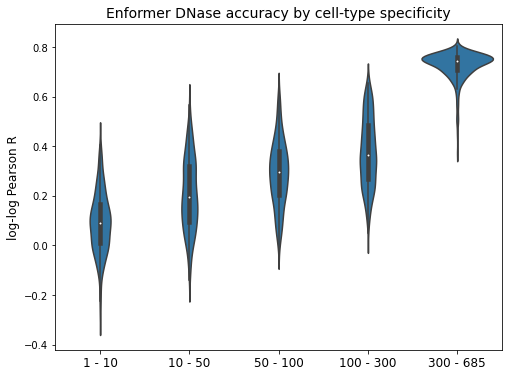

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=corrs, order=[str(b) for b in bins], color="tab:blue")
plt.ylabel("log-log Pearson R", fontsize=12)
plt.xticks(np.arange(len(bins)), [f"{b_0} - {b_1}" for b_0, b_1 in bins], fontsize=12)
plt.title("Enformer DNase accuracy by cell-type specificity", fontsize=14)
plt.savefig(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins.pdf",
            dpi=300)

In [ ]:
def top_N_precision(preds, targets):
    target_peaks = np.where(targets == True)[0]
    top_N_preds = preds[:len(target_peaks)]
    return sum([pred_i in target_peaks for pred_i in top_N_preds])/len(target_peaks)

target_means = test_preds_dnase_ds.mean(axis=0)
target_stds = test_preds_dnase_ds.astype(np.float32).std(axis=0)
preds_normed = (test_preds_dnase_ds_in_peaks - target_means)/target_stds
pred_argsort = np.argsort(preds_normed, axis=1)[:, ::-1]

In [88]:
def top_N_precision(preds, targets):
    target_peaks = np.where(targets == True)[0]
    top_N_preds = preds[:len(target_peaks)]
    return sum([pred_i in target_peaks for pred_i in top_N_preds])/len(target_peaks)

precision_per_peak = []
for i in tqdm(range(preds_normed.shape[0])):
    precision_per_peak.append(top_N_precision(pred_argsort[i, :], 
                                              test_targets_dnase_ds_in_peaks_binary[i, :]))
precision_per_peak = np.array(precision_per_peak)

100%|██████████| 607935/607935 [00:25<00:00, 23944.25it/s]


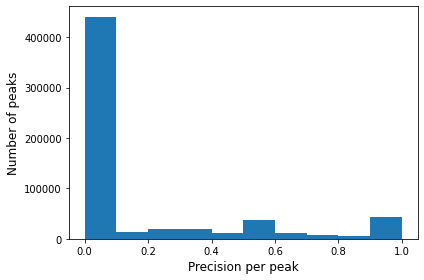

In [113]:
plt.hist(precision_per_peak)
plt.xlabel("Precision per peak", fontsize=12)
plt.ylabel("Number of peaks", fontsize=12)
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/enformer_precision_per_peak.pdf",
            dpi=300)

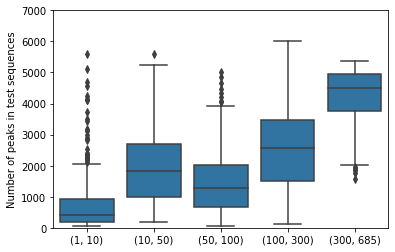

In [131]:
sns.boxplot(data=num_peaks, order=[str(b) for b in bins], color="tab:blue")
plt.ylabel("Number of peaks in test sequences")
plt.ylim(0, 7_000)
plt.savefig(f"{fig_dir}/supp_figs/enformer_num_peaks_in_cell_type_specific_bins.pdf",
            dpi=300)

Split regions by TSS distance

In [24]:
GTEX_GENES_PATH = "/clusterfs/nilah/pooja/genomes/gtex_genes.bed"
gtex_genes = pd.read_csv(GTEX_GENES_PATH, sep="\t", header=0, usecols=["name", "chrom", "txStart"])
gtex_genes.columns = ["Gene", "Chromosome", "Start"]
gtex_genes["End"] = gtex_genes["Start"] + 1

In [25]:
sequence_bins_ds_in_peaks_df = pd.DataFrame(sequence_bins_ds_in_peaks, columns=["Chromosome", "Start", "End"])
sequence_bins_ds_in_peaks_df["Start"] = sequence_bins_ds_in_peaks_df["Start"].astype(int)
sequence_bins_ds_in_peaks_df["End"] = sequence_bins_ds_in_peaks_df["End"].astype(int)
sequence_bins_ds_in_peaks_df["TSS distance"] = pr.PyRanges(sequence_bins_ds_in_peaks_df).nearest(
    pr.PyRanges(gtex_genes)).df["Distance"].values

In [26]:
np.percentile(sequence_bins_ds_in_peaks_df["TSS distance"], [0,33,67,100])

array([     0.  ,   8851.22,  34701.  , 502796.  ])

In [39]:
tss_distance_bins = [(0, 8851), (8851, 34701), (34701, np.inf)]

for tss_bin_start, tss_bin_end in tss_distance_bins:
    sequence_bins_ds_in_peaks_df.loc[(sequence_bins_ds_in_peaks_df["TSS distance"] >= tss_bin_start) &
                                 (sequence_bins_ds_in_peaks_df["TSS distance"] < tss_bin_end), "TSS distance bin"] = f"{tss_bin_start}-{tss_bin_end}"
    

In [40]:
sequence_bins_ds_in_peaks_df["TSS distance bin"].value_counts()

8851-34701    206701
34701-inf     200622
0-8851        200612
Name: TSS distance bin, dtype: int64

In [41]:
bins = [(1, 10), (10, 50), (50, 100), 
        (100, 300), (300, 685)]

peak_in_num_cell_types = test_targets_dnase_ds_in_peaks_binary.sum(axis=1)
corrs = pd.DataFrame([])

for ti in tqdm(range(test_targets_dnase_ds_in_peaks_binary.shape[1])):
    ti_inds = np.where(test_targets_dnase_ds_in_peaks_binary[:,ti] == True)[0]
    
    if len(ti_inds) > 1000:  # only compute accuracy for tracks that have at least 1,000 peaks
        for (bin_min, bin_max) in bins:   
            bin_inds = np.where((peak_in_num_cell_types >= bin_min) &
                                (peak_in_num_cell_types < bin_max))[0]
            bin_inds = np.intersect1d(ti_inds, bin_inds)
            
            for tss_bin_start, tss_bin_end in tss_distance_bins:
                tss_bin_inds = sequence_bins_ds_in_peaks_df[(sequence_bins_ds_in_peaks_df["TSS distance"] >= tss_bin_start) &
                                                             (sequence_bins_ds_in_peaks_df["TSS distance"] < tss_bin_end)].index.values
                tss_bin_inds = np.intersect1d(ti_inds, tss_bin_inds)
                tss_cell_type_specificity_bin_inds = np.intersect1d(bin_inds, tss_bin_inds)
            
                if len(tss_cell_type_specificity_bin_inds) > 25: # only compute accuracy for tracks that have at least 25 peaks
                    test_targets_ti_log = np.log2(test_targets_dnase_ds_in_peaks[tss_cell_type_specificity_bin_inds,ti].astype("float32") + 1)
                    test_preds_ti_log = np.log2(test_preds_dnase_ds_in_peaks[tss_cell_type_specificity_bin_inds,ti].astype("float32") + 1)
                    corrs = corrs.append({"ti": ti,
                                          "TSS distance bin": f"{tss_bin_start}-{tss_bin_end}",
                                          "Cell type specificity bin": f"({bin_min}, {bin_max})",
                                          "Pearson R": pearsonr(test_targets_ti_log, test_preds_ti_log)[0],
                                          "Number of peaks": len(tss_cell_type_specificity_bin_inds),
                                          "# Peaks in cell type specificity & distance bin /  # peaks in distance bin": len(tss_cell_type_specificity_bin_inds)/len(tss_bin_inds),
                                          "# Peaks in cell type specificity & distance bin /  # peaks in cell type specificity bin": len(tss_cell_type_specificity_bin_inds)/len(bin_inds)},
                                         ignore_index=True)
                    
        for tss_bin_start, tss_bin_end in tss_distance_bins:
            tss_bin_inds = sequence_bins_ds_in_peaks_df[(sequence_bins_ds_in_peaks_df["TSS distance"] >= tss_bin_start) &
                                                        (sequence_bins_ds_in_peaks_df["TSS distance"] < tss_bin_end)].index.values
            tss_bin_inds = np.intersect1d(ti_inds, tss_bin_inds)
            
            if len(tss_bin_inds) > 500: # only compute accuracy for tracks that have at least 1000 peaks
                test_targets_ti_log = np.log2(test_targets_dnase_ds_in_peaks[tss_bin_inds,ti].astype("float32") + 1)
                test_preds_ti_log = np.log2(test_preds_dnase_ds_in_peaks[tss_bin_inds,ti].astype("float32") + 1)
                corrs = corrs.append({"ti": ti,
                                      "TSS distance bin": f"{tss_bin_start}-{tss_bin_end}",
                                      "Cell type specificity bin": f"All",
                                      "Pearson R": pearsonr(test_targets_ti_log, test_preds_ti_log)[0],
                                      "Number of peaks": len(tss_bin_inds),
                                      "# Peaks in cell type specificity & distance bin /  # peaks in distance bin": 1,
                                      "# Peaks in cell type specificity & distance bin /  # peaks in cell type specificity bin": len(tss_bin_inds)/len(ti_inds)}, ignore_index=True)

tracks_to_keep = corrs["ti"].value_counts()[corrs["ti"].value_counts() == 18].index.values
corrs = corrs[corrs["ti"].isin(tracks_to_keep)]
corrs["log10 Number of peaks"] = np.log10(corrs["Number of peaks"])

corrs.to_csv(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins_by_tss_distance.csv",
             header=True, index=True)


100%|██████████| 684/684 [05:12<00:00,  2.19it/s]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

(1, 10)_8851-34701 vs. (1, 10)_34701-inf: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:9.411e-01 U_stat=8.150e+04
(10, 50)_0-8851 vs. (10, 50)_8851-34701: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.777e-01 U_stat=8.626e+04
(10, 50)_8851-34701 vs. (10, 50)_34701-inf: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:6.469e-01 U_stat=8.563e+04
(50, 100)_0-8851 vs. (50, 100)_8851-34701: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:8.136e-03 U_stat=9.530e+04
(50, 100)_8851-34701 vs. (50, 100)_34701-inf: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.627e-01 U_stat=8.640e+04
(100, 300)_0-8851 vs. (100, 300)_8851-34701: Mann-Whitney-Wilcoxon test greater wit

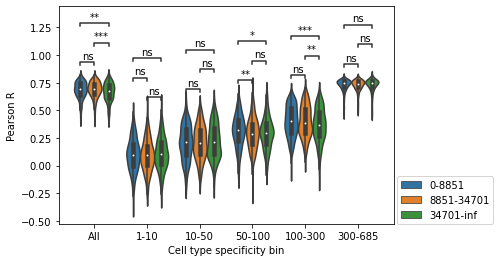

In [62]:
x = "Cell type specificity bin"
y = "Pearson R"
hue = "TSS distance bin"
order = ["All"] + [str(b) for b in bins]
hue_order = [f"{tss_bin_start}-{tss_bin_end}" for tss_bin_start, tss_bin_end in tss_distance_bins]
pairs = [[((bin_, "0-8851"), (bin_, "8851-34701")),
          ((bin_, "0-8851"), (bin_, "34701-inf")),
         ((bin_, "8851-34701"), (bin_, "34701-inf"))] for bin_ in order]
pairs = list(itertools.chain(*pairs))

ax = sns.violinplot(data=corrs, x=x, hue=hue, y=y, order=order, hue_order=hue_order)
annotator = Annotator(ax, pairs, data=corrs, 
                      x=x, y=y, hue=hue, order=order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='inside', 
                    comparisons_correction="fdr_bh")
annotator.apply_test()
annotator.annotate()
plt.xticks(np.arange(len(order)), ["All"] + [f"{b[0]}-{b[1]}" for b in bins])
plt.legend(loc=(1.01,0))
plt.savefig(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins_by_tss_distance.pdf",
            dpi=300)

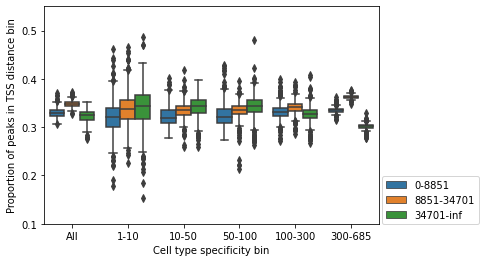

In [66]:
sns.boxplot(data=corrs, x="Cell type specificity bin", hue="TSS distance bin",
            y="# Peaks in cell type specificity & distance bin /  # peaks in cell type specificity bin",
              order=["All"] + [str(b) for b in bins], 
            hue_order=[f"{tss_bin_start}-{tss_bin_end}" for tss_bin_start, tss_bin_end in tss_distance_bins])
plt.ylim(0.1, 0.55)
plt.ylabel("Proportion of peaks in TSS distance bin")
plt.xticks(np.arange(len(order)), ["All"] + [f"{b[0]}-{b[1]}" for b in bins])
plt.legend(loc=(1.01,0))
plt.savefig(f"{fig_dir}/fig2/enformer_reference_accuracy_cell_type_specific_bins_by_tss_distance_proportion_seqs.pdf",
            dpi=300)

Sei

In [8]:
data_dir = "/global/scratch/users/poojakathail/sei"
sei_profiles = np.load(f'{data_dir}/sei-framework/resources/sei_profiles.npy')
sei_profiles = np.array([i.split("|")[1].strip() for i in sei_profiles])
dnase_atac_targets = np.union1d(np.where(sei_profiles == "DNase")[0],
                                np.where(sei_profiles == "ATAC-seq")[0])

In [14]:
# read in targets and predictions
test_predictions = h5py.File(f'{data_dir}/performance_curves/sei_data/test_predictions.h5','r')

targets = test_predictions['targets']
targets = targets[:, dnase_atac_targets]
peak_in_num_cell_types = targets.sum(axis=1)
preds = test_predictions['predictions']
preds = preds[:, dnase_atac_targets]

In [100]:
bins = [(1, 25), (25, 100), (100, 500), 
        (500, 1000), (1000, 2373)]
auc = pd.DataFrame([], index=np.arange(targets.shape[1]))
auprc  = pd.DataFrame([], index=np.arange(targets.shape[1]))
num_peaks = pd.DataFrame([], index=np.arange(targets.shape[1]))

peak_in_at_least_10_tracks = np.where(peak_in_num_cell_types > 10)[0]

for ti in tqdm(range(targets.shape[1])):
    ti_inds = np.where(targets[:,ti] == 1)[0]
    
    if len(ti_inds) > 1000:  # only compute accuracy for tracks that have at least 1,000 peaks
        for (bin_min, bin_max) in bins:   
            bin_inds = np.where((peak_in_num_cell_types[ti_inds] >= bin_min) &
                                (peak_in_num_cell_types[ti_inds] < bin_max))[0]
            bin_inds = ti_inds[bin_inds]
            
            if len(bin_inds) > 50: # only compute accuracy for tracks that have at least 50 peaks'
                num_peaks.loc[ti, f"({bin_min}, {bin_max})"] = len(bin_inds)
                
                # sample negatives
                neg_ti_inds = np.where(targets[:,ti] == 0)[0]
                neg_ti_inds = np.intersect1d(neg_ti_inds, peak_in_at_least_10_tracks)
                neg_ti_inds = np.random.choice(neg_ti_inds, size=len(bin_inds), replace=False)
                bin_inds = np.concatenate([bin_inds, neg_ti_inds])
                
                auc.loc[ti, f"({bin_min}, {bin_max})"] = roc_auc_score(targets[bin_inds,ti], 
                                                                       preds[bin_inds,ti])
                auprc.loc[ti, f"({bin_min}, {bin_max})"] = average_precision_score(targets[bin_inds,ti], 
                                                                                   preds[bin_inds,ti])
                

auc = auc[auc.isna().sum(axis=1) == 0]
auprc = auprc[auprc.isna().sum(axis=1) == 0]
num_peaks = num_peaks[num_peaks.isna().sum(axis=1) == 0]

auc.to_csv(f"{fig_dir}/fig2/sei_auc_cell_type_specific_bins.csv",
             header=True, index=True)
auprc.to_csv(f"{fig_dir}/fig2/sei_auprc_cell_type_specific_bins.csv",
             header=True, index=True)
num_peaks.to_csv(f"{fig_dir}/fig2/sei_num_peaks_in_cell_type_specific_bins.csv",
             header=True, index=True)

100%|██████████| 2372/2372 [22:39<00:00,  1.74it/s]


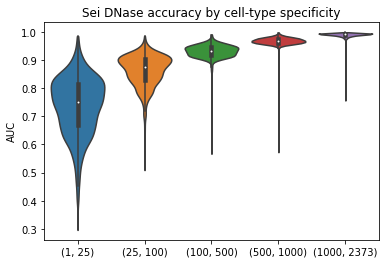

In [101]:
sns.violinplot(data=auc, order=[str(b) for b in bins], cut=0, scale="width")
plt.ylabel("AUC")
plt.title("Sei DNase accuracy by cell-type specificity")
plt.savefig(f"{fig_dir}/fig2/sei_auc_cell_type_specific_bins.pdf",
            dpi=300)

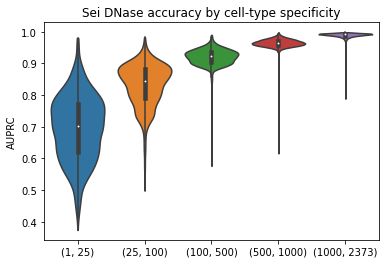

In [102]:
sns.violinplot(data=auprc, order=[str(b) for b in bins], cut=0, scale="width")
plt.ylabel("AUPRC")
plt.title("Sei DNase accuracy by cell-type specificity")
plt.savefig(f"{fig_dir}/fig2/sei_auprc_cell_type_specific_bins.pdf",
            dpi=300)

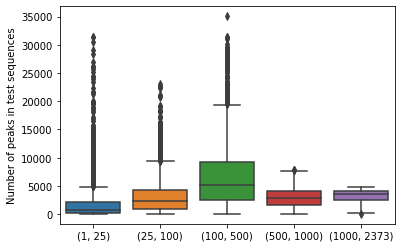

In [103]:
sns.boxplot(data=num_peaks, order=[str(b) for b in bins])
plt.ylabel("Number of peaks in test sequences")
# plt.ylim(0, 20000)
plt.savefig(f"{fig_dir}/supp_figs/sei_num_peaks_in_cell_type_specific_bins.pdf",
            dpi=300)

Test on the same region splits as LDSC heritability analysis

In [36]:
enformer_dir = "/global/scratch/users/poojakathail/enformer"

# mapping between traits and Enformer cell types
enformer_targets = pd.read_csv(f"{enformer_dir}/targets_human_with_tissue_category.txt", sep="\t", index_col=0)
enformer_targets = enformer_targets.loc[dnase_atac_targets]
tissues = enformer_targets["Tissue category"].unique()
tissues = np.setdiff1d(tissues, ['Other'])

bed_file_dir = "/global/scratch/users/poojakathail/enformer/ldsc/bed_files"

sequence_bins_df = pd.DataFrame(sequence_bins_ds, columns=["chr", "start", "end"])
sequence_bins_df["start"] = sequence_bins_df["start"].astype(int)
sequence_bins_df["end"] = sequence_bins_df["end"].astype(int)
sequence_bins_df["index"] = sequence_bins_df.index.values

In [58]:
tissue_peak_inds = {}
for tissue in tissues:
    tissue_formatted = tissue.replace("/", "_")
    tissue_peak_inds[tissue] = {}
    tissue_peaks = pd.read_csv(f"{bed_file_dir}/{tissue_formatted}_bin_0_cell_type_peak_sequences.hg38.bed", sep="\t", names=["chr", "start", "end", "i"])
    tissue_peak_inds[tissue]["High"] = sequence_bins_df.merge(tissue_peaks, on=["chr", "start", "end"])["index"].values
    
    tissue_peaks = pd.read_csv(f"{bed_file_dir}/{tissue_formatted}_bin_1_cell_type_peak_sequences.hg38.bed", sep="\t", names=["chr", "start", "end", "i"])
    tissue_peak_inds[tissue]["Low"] = sequence_bins_df.merge(tissue_peaks, on=["chr", "start", "end"])["index"].values

In [59]:
corrs = pd.DataFrame([])

for tissue in tqdm(tissues):
    tissue_targets = enformer_targets[enformer_targets["Tissue category"] == tissue].index.values
    for ti in tissue_targets:
        for bin_ in ["Low", "High"]:
            test_targets_ti_log = np.log2(test_targets_dnase_ds[tissue_peak_inds[tissue][bin_], ti].astype("float32") + 1)
            test_preds_ti_log = np.log2(test_preds_dnase_ds[tissue_peak_inds[tissue][bin_], ti].astype("float32") + 1)
            corr = pearsonr(test_targets_ti_log, test_preds_ti_log)[0]
            corrs = corrs.append({"Tissue": tissue,
                                  "Track": ti,
                                  "Cell type specificity": bin_,
                                  "Pearson R": corr}, ignore_index=True)

100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


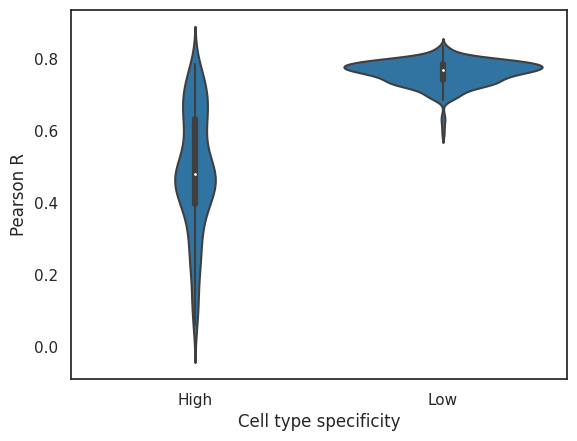

In [75]:
g = sns.violinplot(data=corrs,  x="Cell type specificity", y="Pearson R", order=["High",  "Low"],color="tab:blue")
plt.savefig(f"{fig_dir}/supp_figs/enformer_reference_accuracy_per_tissue_high_low_bins_pooled_across_tissues.pdf",
            dpi=300)

### LDSC results

Basic peak distributions for each tissue category

In [104]:
enformer_dir = "/global/scratch/users/poojakathail/enformer"

# mapping between traits and Enformer cell types
enformer_targets = pd.read_csv(f"{enformer_dir}/targets_human_with_tissue_category.txt", sep="\t", index_col=0)

## read in processed target data
with open(f"{enformer_dir}/train_targets_peaks.npz", "rb") as f:
    train_targets_peaks = np.load(f)

with open(f"{enformer_dir}/val_test_targets_peaks.npz", "rb") as f:
    val_test_targets_peaks = np.load(f)
    
all_targets_peaks = np.concatenate([train_targets_peaks, val_test_targets_peaks])
del train_targets_peaks, val_test_targets_peaks

In [1]:
import pandas as pd
enformer_dir = "/global/scratch/users/poojakathail/enformer"

# mapping between traits and Enformer cell types
enformer_targets = pd.read_csv(f"{enformer_dir}/targets_human_with_tissue_category.txt", sep="\t", index_col=0)


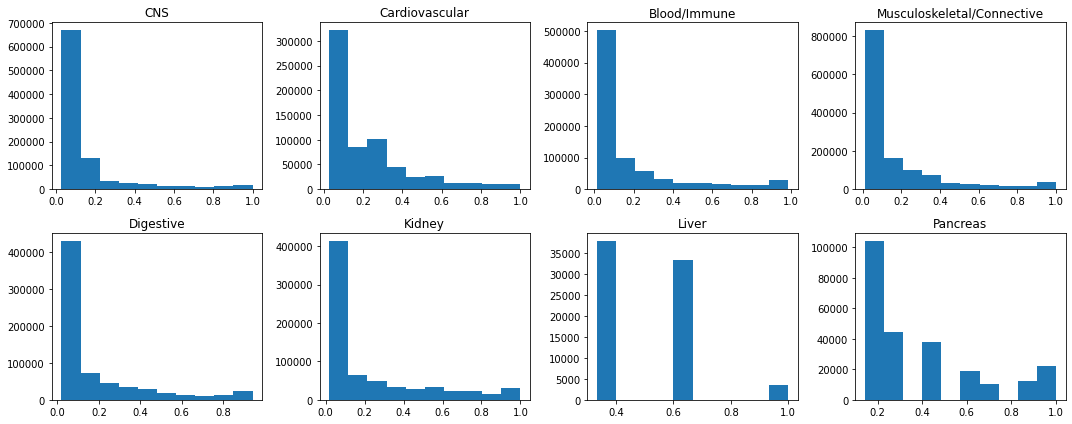

In [105]:
# for each tissue category, for each peak present in tracks of that category plot the proportion of tracks in the category it's a peak in
tissues = ['CNS',  'Cardiovascular', 'Blood/Immune', 'Musculoskeletal/Connective', 
           'Digestive', 'Kidney', 'Liver', 'Pancreas']
fig, ax = plt.subplots(2, 4, figsize=(15, 6))

for i, tissue in enumerate(tissues):
    tissue_inds = enformer_targets[enformer_targets["Tissue category"] == tissue].index.values
    tissue_peaks = all_targets_peaks[:, tissue_inds].sum(axis=1)/len(tissue_inds)
    ax[i // 4, i % 4].hist(tissue_peaks[np.where(tissue_peaks > 0)[0]])
    ax[i // 4, i % 4].set_title(tissue)
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/enformer_per_tissue_peak_distributions_within_tissue_tracks.pdf",
            dpi=300)

CNS 37
Cardiovascular 35
Blood/Immune 72
Musculoskeletal/Connective 89
Digestive 53
Kidney 55
Liver 3
Pancreas 7


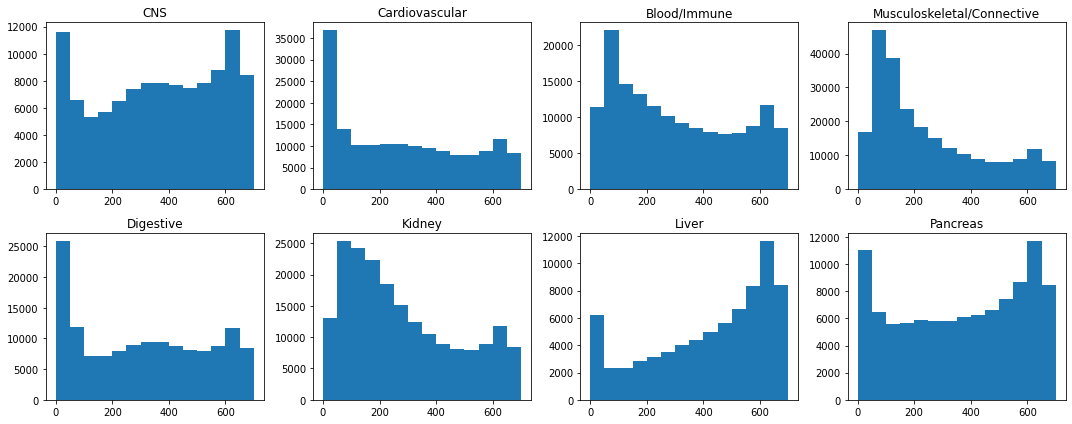

In [106]:
# for each tissue category, for peaks present in at least 30% of tracks of that category plot the total number of tracks (across all categories) they are a peak in 
proportion_tissue_peaks_threshold = 0.3

fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for i, tissue in enumerate(tissues):
    tissue_inds = enformer_targets[enformer_targets["Tissue category"] == tissue].index.values
    print(tissue, len(tissue_inds))
    tissue_peaks = all_targets_peaks[:, tissue_inds].sum(axis=1)/len(tissue_inds)
    
    inds = np.where((tissue_peaks > proportion_tissue_peaks_threshold))[0]
    ax[i // 4, i % 4].hist(all_targets_peaks[inds,:].sum(axis=1), bins=np.arange(0, 750, 50))
    ax[i // 4, i % 4].set_title(tissue)
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/enformer_per_tissue_peak_distributions_across_all_tracks.pdf",
            dpi=300)

Read in LDSC results

In [4]:
results_dir="/global/scratch/users/poojakathail/enformer/ldsc/out"

trait_metadata = {"Height": ["50_irnt", "Musculoskeletal/Connective"],
                  "BMI": ["23104_irnt", "CNS"],
                  "Asthma": ["6152_8", "Blood/Immune"],
                  "Diabetes": ["2443", "Pancreas"],
                  "Eczema": ["6152_9", "Blood/Immune"],
                  "Smoking status (Never)": ["20116_0", "CNS"],
                  "Heel T-score": ["78_irnt", "Cardiovascular"]}

annots = ["less_cell_type_specific", "less_cell_type_specific_mean_sad_bin_bottom_0.5", "less_cell_type_specific_mean_sad_bin_top_0.5",
          "more_cell_type_specific", "more_cell_type_specific_mean_sad_bin_bottom_0.5", "more_cell_type_specific_mean_sad_bin_top_0.5",
          "less_cell_type_specific_mean_sad_bin_bottom_0.3", "less_cell_type_specific_mean_sad_bin_top_0.3", 
          "less_cell_type_specific_mean_sad_bin_bottom_0.1", "less_cell_type_specific_mean_sad_bin_top_0.1",
          "more_cell_type_specific_mean_sad_bin_bottom_0.3", "more_cell_type_specific_mean_sad_bin_top_0.3",
          "more_cell_type_specific_mean_sad_bin_bottom_0.1", "more_cell_type_specific_mean_sad_bin_top_0.1"]
runs = ["baseline", "no_baseline", "baseline_remove_enhancer_promoter_annots"]

ldsc_results = {}
for run in runs:
    ldsc_results[run] = {}
    for trait, (trait_code, trait_tissue) in trait_metadata.items():
        trait_tissue_formatted = trait_tissue.replace('/', '_')

        trait_results = []
        for annot in annots:
            trait_results.append(pd.read_csv(
            f"{results_dir}/{trait_code}_{run}_{trait_tissue_formatted}_{annot}.results", 
            sep="\t", header=0, index_col=0))

        ldsc_results[run][trait]  = pd.concat(trait_results)

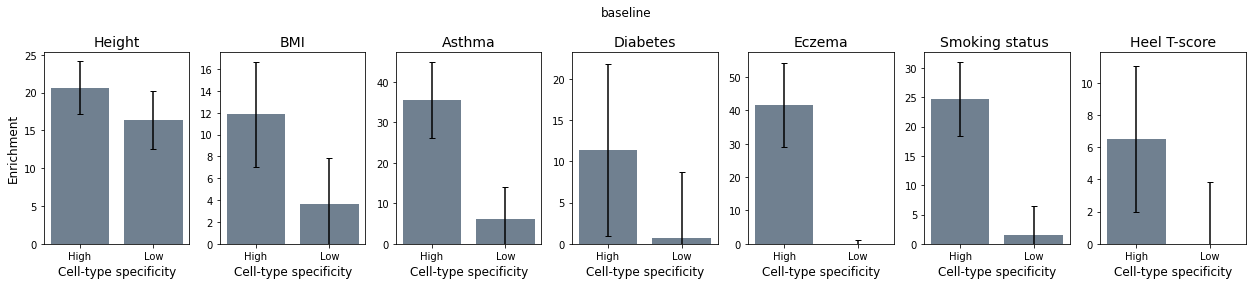

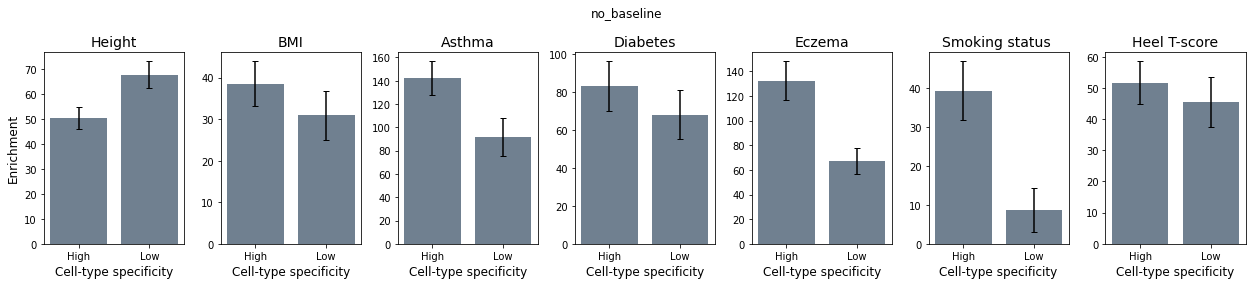

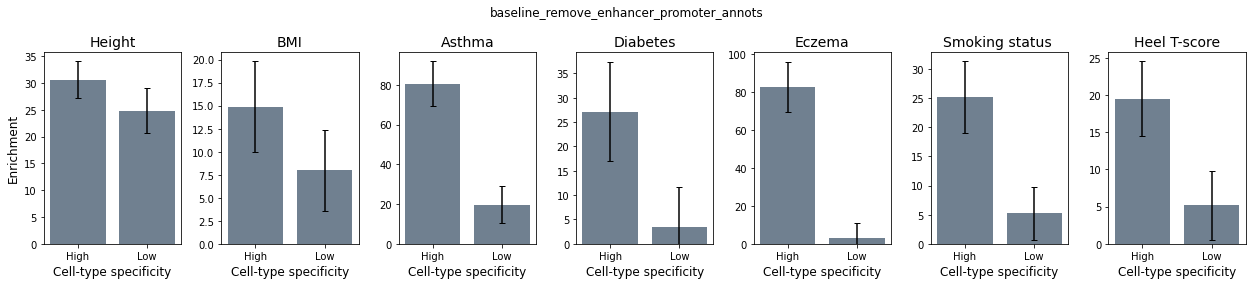

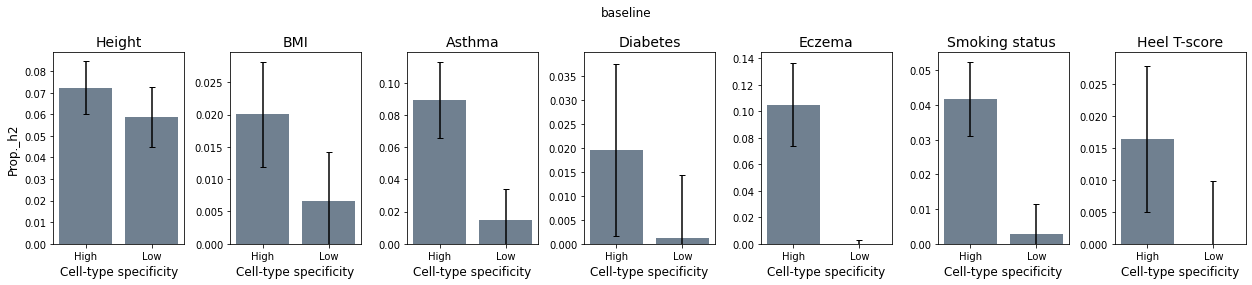

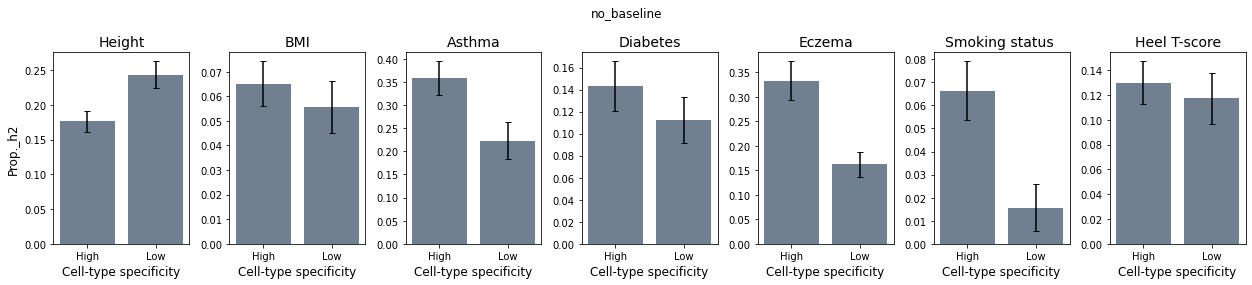

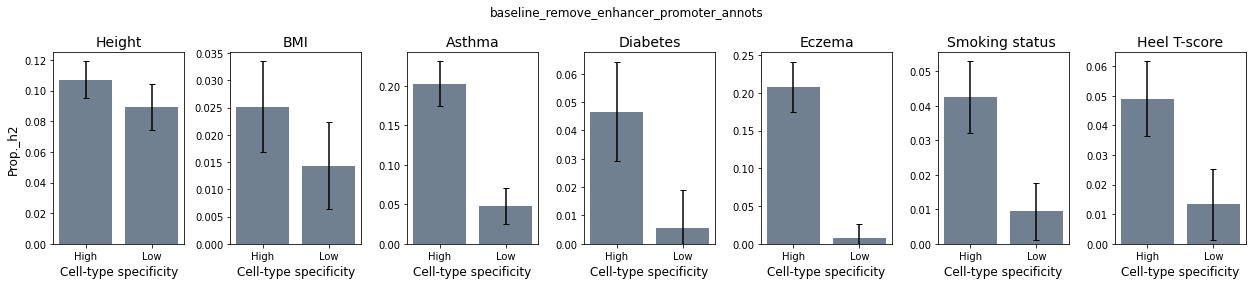

In [5]:
cmap = plt.get_cmap("tab20b")
plot_cols = ["Enrichment", "Prop._h2"]

for plot_col in plot_cols:
    for run in runs:
        fig, ax = plt.subplots(1, len(trait_metadata), figsize=(2.5*len(trait_metadata), 4*1))
        for j, (trait, (trait_code, trait_tissue)) in enumerate(trait_metadata.items()):
            cols = [f'{trait_tissue}_more_cell_type_specificL2_1',
                    f'{trait_tissue}_less_cell_type_specificL2_1']

            ax[j].bar(np.arange(len(cols)),
                      ldsc_results[run][trait].loc[cols, plot_col],
                      yerr=ldsc_results[run][trait].loc[cols, f"{plot_col}_std_error"],
                      capsize=3, color="slategray")

            ax[j].set_ylim(bottom=0, top=None)
            ax[j].set_title(trait.split("(")[0], fontsize=14)
            ax[j].set_xticks(np.arange(2))
            ax[j].set_xticklabels(["High", "Low"]) 
            ax[j].set_xlabel("Cell-type specificity", fontsize=12)
            if j == 0:
                ax[j].set_ylabel(plot_col, fontsize=12)
        plt.suptitle(run)
        plt.tight_layout()
        plt.savefig(f"{fig_dir}/fig2/cell_type_specific_heritability_{plot_col}_enformer_tracks_{run}.pdf",
            dpi=300)

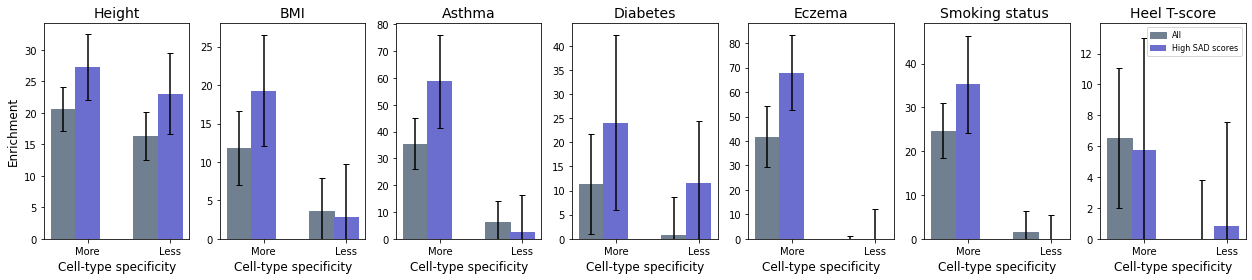

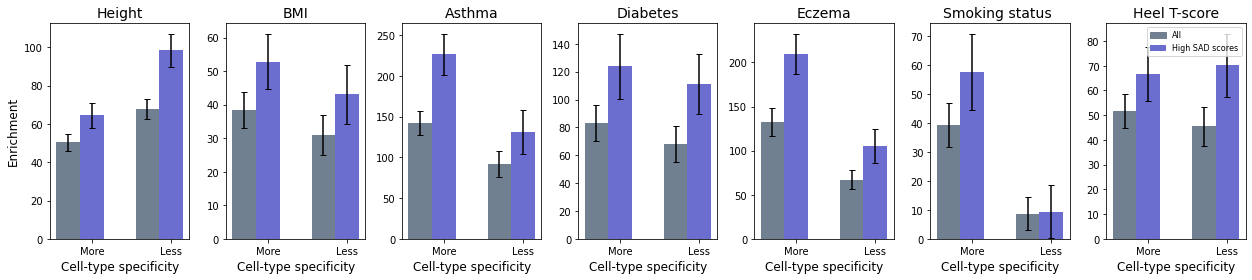

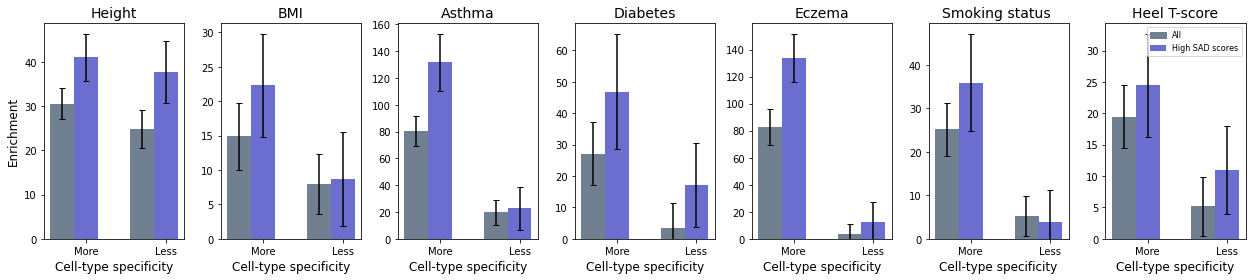

In [22]:
width = 0.3
cmap = plt.get_cmap("tab20b")
plot_col = "Enrichment"

for run in runs:
    fig, ax = plt.subplots(1, len(trait_metadata), figsize=(2.5*len(trait_metadata), 4*1))
    for j, (trait, (trait_code, trait_tissue)) in enumerate(trait_metadata.items()):
        # plot all peaks in each cell type specificity bin first as a point of reference
        cols = [f'{trait_tissue}_more_cell_type_specificL2_1',
                f'{trait_tissue}_less_cell_type_specificL2_1']
        label = "All"
        ax[j].bar(np.arange(len(cols)),
                      ldsc_results[run][trait].loc[cols, plot_col], width,
                      yerr=ldsc_results[run][trait].loc[cols, f"{plot_col}_std_error"],
                      capsize=3, label=label, color="slategray", edgecolor="slategray")
        
        sad_bin="top_0.5"
        cols = [f'{trait_tissue}_more_cell_type_specific_mean_sad_bin_{sad_bin}L2_1',
                f'{trait_tissue}_less_cell_type_specific_mean_sad_bin_{sad_bin}L2_1']
        label = "High SAD scores"
        ax[j].bar(np.arange(len(cols))+width,
                  ldsc_results[run][trait].loc[cols, plot_col], width,
                  yerr=ldsc_results[run][trait].loc[cols, f"{plot_col}_std_error"],
                  capsize=3, label=label, color=cmap(2))

        ax[j].set_ylim(bottom=0, top=None)
        ax[j].set_title(trait.split("(")[0], fontsize=14)
        ax[j].set_xticks(np.arange(2)+width)
        ax[j].set_xticklabels(["More", "Less"]) 
        ax[j].set_xlabel("Cell-type specificity", fontsize=12)
        if j == 0:
            ax[j].set_ylabel(plot_col, fontsize=12)
        if j == len(trait_metadata) - 1:
            ax[j].legend(loc="upper right", fontsize=8)
    # plt.suptitle(run)
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/fig2/cell_type_specific_heritability_{plot_col}_enformer_sad_score_stratified_with_all_high_only_{run}.pdf",
                dpi=300)

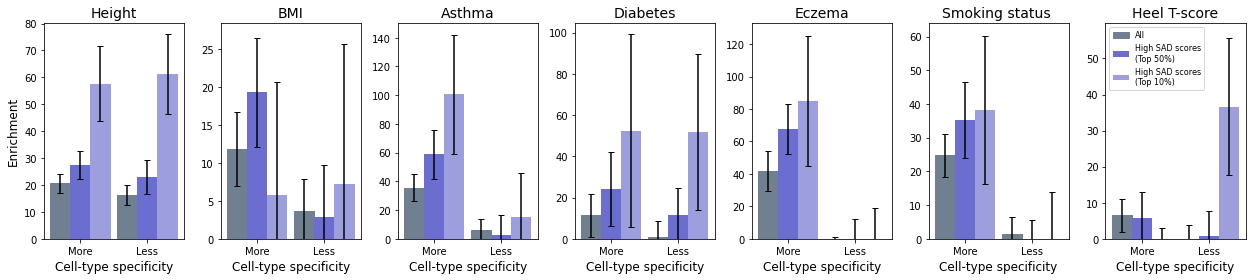

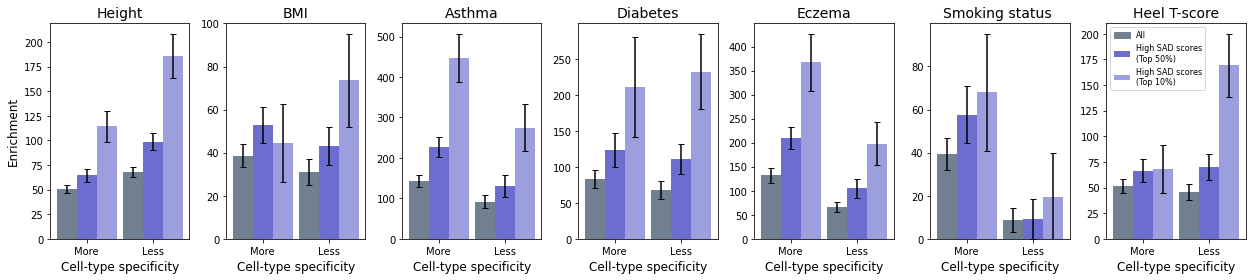

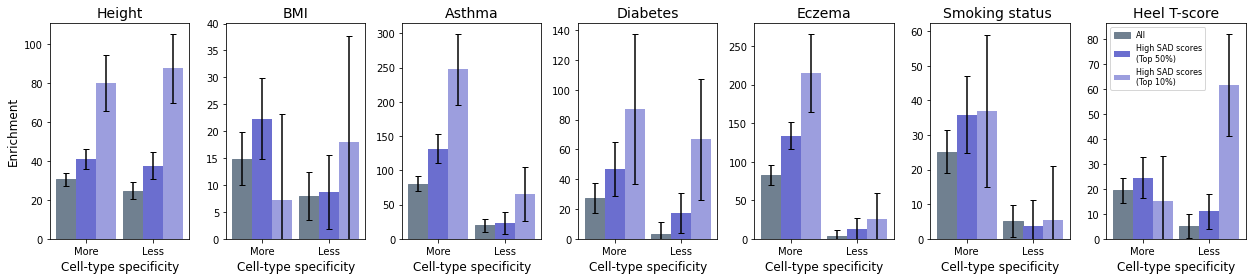

In [31]:
width = 0.3
cmap = plt.get_cmap("tab20b")
plot_col = "Enrichment"

for run in runs:
    fig, ax = plt.subplots(1, len(trait_metadata), figsize=(2.5*len(trait_metadata), 4*1))
    for j, (trait, (trait_code, trait_tissue)) in enumerate(trait_metadata.items()):
        # plot all peaks in each cell type specificity bin first as a point of reference
        cols = [f'{trait_tissue}_more_cell_type_specificL2_1',
                f'{trait_tissue}_less_cell_type_specificL2_1']
        label = "All"
        ax[j].bar(np.arange(len(cols)),
                      ldsc_results[run][trait].loc[cols, plot_col], width,
                      yerr=ldsc_results[run][trait].loc[cols, f"{plot_col}_std_error"],
                      capsize=3, label=label, color="slategray", edgecolor="slategray")
        
        for i, sad_bin in enumerate(["top_0.5", "top_0.1"]):
            cols = [f'{trait_tissue}_more_cell_type_specific_mean_sad_bin_{sad_bin}L2_1',
                    f'{trait_tissue}_less_cell_type_specific_mean_sad_bin_{sad_bin}L2_1']
            if i == 0:
                label = "High SAD scores\n(Top 50%)"
            else:
                label = "High SAD scores\n(Top 10%)"
            ax[j].bar(np.arange(len(cols))+width*(i+1),
                      ldsc_results[run][trait].loc[cols, plot_col], width,
                      yerr=ldsc_results[run][trait].loc[cols, f"{plot_col}_std_error"],
                      capsize=3, label=label, color=cmap(2+i))

        ax[j].set_ylim(bottom=0, top=None)
        ax[j].set_title(trait.split("(")[0], fontsize=14)
        ax[j].set_xticks(np.arange(2)+width)
        ax[j].set_xticklabels(["More", "Less"]) 
        ax[j].set_xlabel("Cell-type specificity", fontsize=12)
        if j == 0:
            ax[j].set_ylabel(plot_col, fontsize=12)
        if j == len(trait_metadata) - 1:
            ax[j].legend(loc="upper left", fontsize=8)
    # plt.suptitle(run)
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/fig2/cell_type_specific_heritability_{plot_col}_enformer_sad_score_stratified_0.1_0.5_threshold_with_all_high_only_{run}.pdf",
                dpi=300)

### GTEx eQTL classification

Read in predictions

In [162]:
enformer_data_dir = "/clusterfs/nilah/richard/basenji2/data_pretrained_basenji2/human"
human_targets = pd.read_csv(f"{enformer_data_dir}/targets.txt", sep="\t", index_col=0)
enformer_dnase_atac_targets = np.where([("DNASE" in i) or ("ATAC" in i) 
                               for i in human_targets["description"]])[0]

sei_data_dir = "/global/scratch/users/poojakathail/sei"
sei_profiles = np.load(f'{sei_data_dir}/sei-framework/resources/sei_profiles.npy')
sei_profiles = np.array([i.split("|")[1].strip() for i in sei_profiles])
sei_dnase_atac_targets = np.union1d(np.where(sei_profiles == "DNase")[0],
                                np.where(sei_profiles == "ATAC-seq")[0])

dnase_atac_targets = {"enformer": enformer_dnase_atac_targets,
                      "sei": sei_dnase_atac_targets}

In [163]:
enformer_dir = "/global/scratch/users/poojakathail/enformer"
tissues = os.listdir(f"{enformer_dir}/gtex_fine/susie")
tissues = [t.split(".")[0] for t in tissues]

## read in processed target data
with open(f"{enformer_dir}/train_targets_peaks.npz", "rb") as f:
    train_targets_peaks = np.load(f)

with open(f"{enformer_dir}/val_test_targets_peaks.npz", "rb") as f:
    val_test_targets_peaks = np.load(f)
    
all_targets_peaks = np.concatenate([train_targets_peaks, val_test_targets_peaks])
del train_targets_peaks, val_test_targets_peaks

peak_in_num_cell_types = all_targets_peaks.sum(axis=1)
del all_targets_peaks

In [164]:
enformer_preds = read_enformer_predictions(tissues)
sei_preds = read_sei_predictions(tissues)

In [165]:
res_all = stratified_classification_performance_all_tissues(tissues, enformer_preds, sei_preds, 
                                                  dnase_atac_targets, peak_in_num_cell_types)
res_all[["Tissue", "Bin", "Model", "AUC", 
         "AUPRC", "Positive set size"]].to_csv(
    f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_metrics.csv", header=True, index=False)

100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


In [18]:
res_all.groupby(["Bin", "Model"])["AUC"].median()

Bin         Model   
(1, 10)     Enformer    0.734296
            Sei         0.727563
(10, 50)    Enformer    0.862320
            Sei         0.926947
(50, 100)   Enformer    0.974173
            Sei         0.963839
(100, 300)  Enformer    0.947659
            Sei         0.971319
Name: AUC, dtype: float64

In [19]:
res_all.groupby(["Bin", "Model"])["AUPRC"].median()

Bin         Model   
(1, 10)     Enformer    0.708314
            Sei         0.713476
(10, 50)    Enformer    0.815187
            Sei         0.904850
(50, 100)   Enformer    0.962535
            Sei         0.955337
(100, 300)  Enformer    0.925269
            Sei         0.961669
Name: AUPRC, dtype: float64

In [167]:
tss_distances = {}
betas = {}
for bin in res_all["Bin"].unique():
    tss_distances[bin] = np.concatenate(res_all[(res_all["Bin"] == bin) & 
                                       (res_all["Model"] == "Enformer")]["TSS distance"].values)
    
    betas[bin] = np.abs(np.concatenate(res_all[(res_all["Bin"] == bin) & 
                                       (res_all["Model"] == "Enformer")]["Beta"].values))

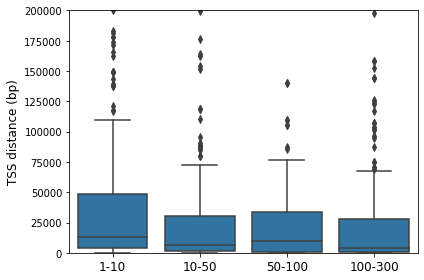

In [27]:
xticks = ["1-10", "10-50", "50-100", "100-300"]

sns.boxplot(data=list(tss_distances.values()), color="tab:blue")
plt.ylim(0, 200_000)
plt.ylabel("TSS distance (bp)", fontsize=12)
plt.xticks(np.arange(len(xticks)), xticks, fontsize=12)
plt.tight_layout()[b
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_bins_tss_distance.pdf",
            dpi=300)

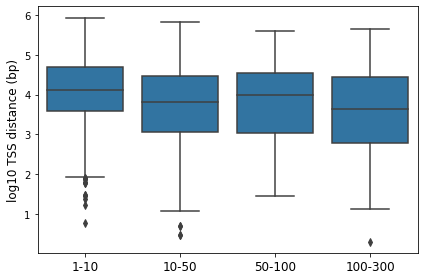

In [174]:
xticks = ["1-10", "10-50", "50-100", "100-300"]

sns.boxplot(data=[np.log10(tss_distances[bin]+1) for bin in tss_distances.keys()], color="tab:blue")
plt.ylabel("log10 TSS distance (bp)", fontsize=12)
plt.xticks(np.arange(len(xticks)), xticks, fontsize=12)
plt.tight_layout()
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_bins_tss_distance_logscale.pdf",
            dpi=300)

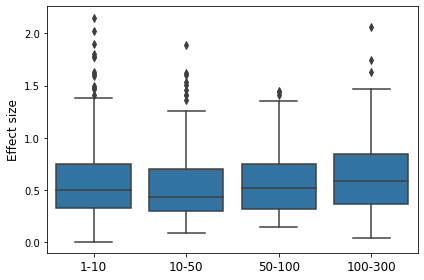

In [28]:
sns.boxplot(data=list(betas.values()), color="tab:blue")
list(tss_distances.keys())
plt.ylabel("Effect size", fontsize=12)
plt.xticks(np.arange(len(xticks)), xticks, fontsize=12)
plt.tight_layout()
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_bins_effect_size.pdf",
            dpi=300)

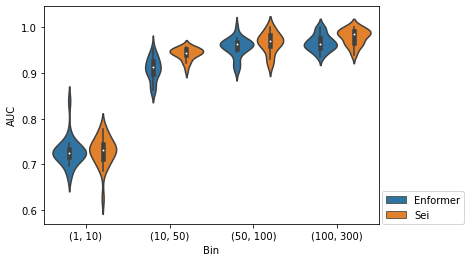

In [58]:
sns.violinplot(data=res_all, x="Bin", y="AUC", hue="Model")
plt.legend(loc=(1.01, 0))
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_auc.pdf",
            dpi=300)

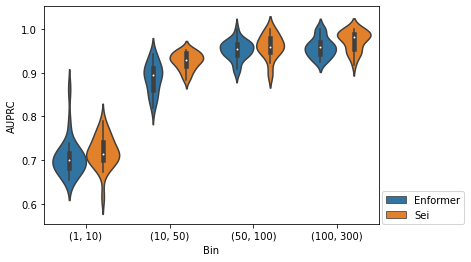

In [59]:
sns.violinplot(data=res_all, x="Bin", y="AUPRC", hue="Model")
plt.legend(loc=(1.01, 0))
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_classification_auprc.pdf",
            dpi=300)

In [176]:
res_all = stratified_direction_performance_all_tissues(tissues, enformer_preds, sei_preds, 
                                                      dnase_atac_targets, peak_in_num_cell_types)
res_all.to_csv(
    f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_direction_metrics.csv", header=True, index=False)

100%|██████████| 49/49 [01:14<00:00,  1.53s/it]


In [177]:
res_all.groupby(["Bin", "Model"])["AUC"].median()

Bin         Model   
(1, 10)     Enformer    0.588141
            Sei         0.579524
(10, 50)    Enformer    0.707074
            Sei         0.719007
(50, 100)   Enformer    0.727997
            Sei         0.717857
(100, 300)  Enformer    0.772601
            Sei         0.731386
Name: AUC, dtype: float64

In [178]:
res_all.groupby(["Bin", "Model"])["AUPRC"].median()

Bin         Model   
(1, 10)     Enformer    0.639415
            Sei         0.640471
(10, 50)    Enformer    0.730855
            Sei         0.753857
(50, 100)   Enformer    0.770271
            Sei         0.785502
(100, 300)  Enformer    0.787577
            Sei         0.770679
Name: AUPRC, dtype: float64

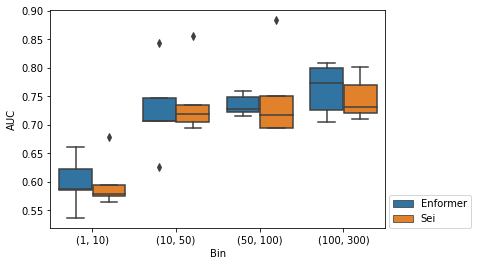

In [184]:
sns.boxplot(data=res_all, x="Bin", y="AUC", hue="Model")
plt.legend(loc=(1.01, 0))
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_direction_auc.pdf",
            dpi=300)

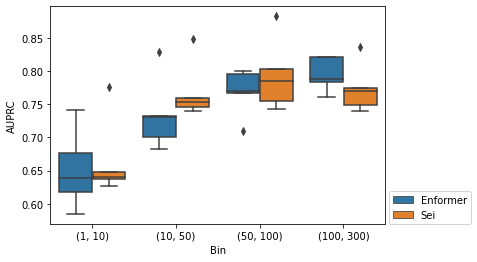

In [182]:
sns.boxplot(data=res_all, x="Bin", y="AUPRC", hue="Model")
plt.legend(loc=(1.01, 0))
plt.savefig(f"{fig_dir}/fig2/enformer_sei_gtex_eqtl_direction_auprc.pdf",
            dpi=300)